## Monte Carlo Methods

In this notebook, you will write your own implementations of many Monte Carlo (MC) algorithms.  

### Part 0: Explore BlackjackEnv

Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [7]:
from collections import defaultdict
import numpy as np
import sys

from plot_utils import plot_blackjack_values
from plot_utils_bj_openai import create_grids, create_plots

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import gymnasium as gym
env = gym.make('Blackjack-v1', sab=True)

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [3]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Execute the code cell below to play Blackjack with a random policy.  

(_The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment._)

In [4]:
for i_episode in range(3):
    observation = env.reset()
    print(observation)
    while True:
        # action = 1 
        action = env.action_space.sample()
        observation, reward, done, truncated, info = env.step(action)
        print(action, observation, reward)
        if done:
            print('End game!')
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

((13, 10, 1), {})
1 (12, 10, 0) 0.0
1 (22, 10, 0) -1.0
End game!
You lost :(

((14, 8, 0), {})
1 (16, 8, 0) 0.0
0 (16, 8, 0) 1.0
End game!
You won :)

((14, 10, 0), {})
0 (14, 10, 0) 1.0
End game!
You won :)



### Part 1: MC Prediction: State Values

In this section, you will write your own implementation of MC prediction (for estimating the state-value function).

We will begin by investigating a policy where the player always sticks if the sum of her cards exceeds 18.  The function `generate_episode_from_limit` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [5]:
def generate_episode_from_limit(bj_env):
    episode = []
    state = bj_env.reset()[0]
    while True:
        action = 0 if state[0] > 18 else 1
        next_state, reward, done, truncated, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Execute the code cell below to play Blackjack with the policy. 

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit` function.*)

In [6]:
for i in range(3):
    print(generate_episode_from_limit(env))

[((15, 10, 0), 1, -1.0)]
[((12, 10, 0), 1, 0.0), ((16, 10, 0), 1, -1.0)]
[((14, 9, 0), 1, -1.0)]


Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `V`: This is a dictionary where `V[s]` is the estimated value of state `s`.  For example, if your code returns the following output:
```
{(4, 7, False): -0.38775510204081631, (18, 6, False): -0.58434296365330851, (13, 2, False): -0.43409090909090908, (6, 7, False): -0.3783783783783784, ...
```
then the value of state `(4, 7, False)` was estimated to be `-0.38775510204081631`.

If you are unfamiliar with how to use `defaultdict` in Python, you are encouraged to check out [this source](https://www.accelebrate.com/blog/using-defaultdict-python/).

In [8]:
def create_policy(env):
    # create policy object 
    policy = defaultdict(int)

    for i in range(env.observation_space[0].n):
        for j in range(env.observation_space[1].n):
            for k in range(env.observation_space[2].n):
                if i >= 20: # sutton and barto policy for Example 5.1 Blackjack 
                    policy[(i, j, k)] = 0 # stick
                else:
                    policy[(i, j, k)] = 1 # hit

    return policy


def plot_policy(policy, usable_ace=0):

    player_count, dealer_count = np.meshgrid(
            # players count, dealers face-up card
            np.arange(12, 22),
            np.arange(1, 11),
        )

    policy_grid = np.apply_along_axis(
            lambda obs: policy[(obs[0], obs[1], usable_ace)],
            axis=2,
            arr=np.dstack([player_count, dealer_count]),
        )
    sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False);
    plt.gca().set_title(f"Policy: usable_ace = {usable_ace}")
    plt.gca().set_xlabel("Player sum")
    plt.gca().set_ylabel("Dealer showing")
    plt.gca().set_xticklabels(range(12, 22));
    plt.gca().set_yticklabels(["A"] + list(range(2, 11)), fontsize=12);

policy = create_policy(env)


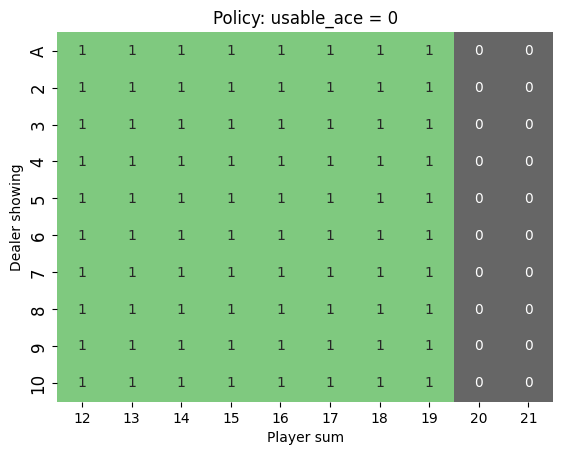

In [9]:
plot_policy(policy, usable_ace=0)


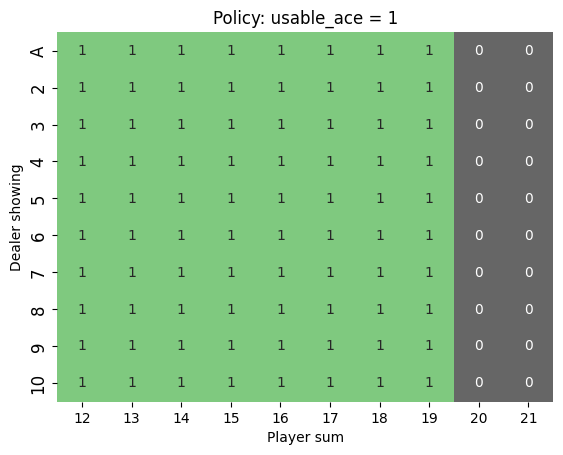

In [10]:

plot_policy(policy, usable_ace=1)

In [11]:
def generate_episode(env, policy):
    '''
    Args:
    - env: blackjack gym environment
    - policy: 
    Returns:
    - list: a list of tuples (state, action, reward) for each state in the episode until termination
    '''

    # initialize list 
    episode = []

    # reset environment 
    terminated = False
    state, _ = env.reset()

    # while not done, i.e. until terminated = True 
    while not terminated:
        # get an action according to policy 
        action = policy[state]

        # execute the action in our environment and receive infos from the environment
        next_state, reward, terminated, truncated, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state 

        # check for termination
        if terminated:
            break 
    
    return episode


In [12]:
def mc_prediction_nz(env, policy, num_episodes, gamma=1.0):
    
    # initialize empty dictionary of lists
    # returns = defaultdict(np.float64)
    returns_sum = defaultdict(np.float64)
    returns_counts = defaultdict(np.float64)
    V = defaultdict(np.float64)

    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # generate an episode of data using the policy 
        episode = generate_episode(env, policy)
        
        # initialize returns for this episode 
        G = 0
    
        # loop over each step of episode backwards
        for t, (state, action, reward) in enumerate(reversed(episode)):
            t = len(episode) - t
            G = G*gamma + reward 
            
            # For first-visit MC
            # check if this state has never been seen before in the episode (and therefore is the first visit to the state)
            if state not in [tup[0] for tup in episode[:t-1]]: 
                # if we've never seen the state in any episode, then initialize counts and sum
                if state not in returns_sum:
                    # initialize sum and count
                    returns_sum[state] = 0
                    returns_counts[state] = 0
                # add the return and increment the count (for the purposes of taking the mean later)
                returns_sum[state] += G
                returns_counts[state] += 1
        
    #  take the average of the returns for each state and assign to value function object
    for state in returns_sum:
        V[state] = returns_sum[state] / returns_counts[state]

    return V


Use the cell below to calculate and plot the state-value function estimate.  (_The code for plotting the value function has been borrowed from [this source](https://github.com/dennybritz/reinforcement-learning/blob/master/lib/plotting.py) and slightly adapted._)

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

Episode 500000/500000.

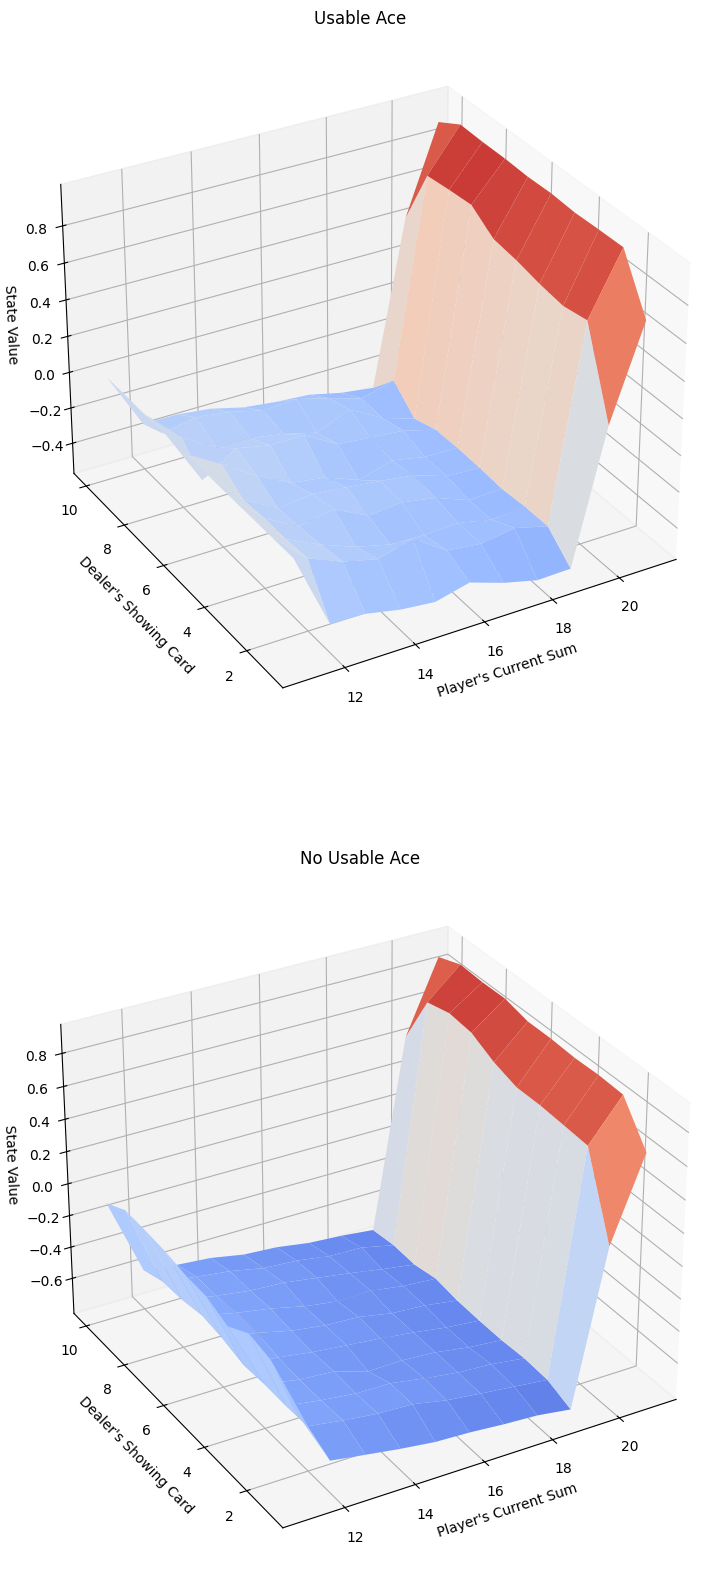

In [14]:
# obtain the value function
# create policy 
policy = create_policy(env)
V = mc_prediction_nz(env, policy, num_episodes=500000, gamma=1.0)

# plot the value function
plot_blackjack_values(V)
plt.show()


### 5.3 Monte Carlo Policy Iteration with Exploring Starts

In [42]:
def generate_episode_exploring_starts(env, policy):
    '''
    Args:
        env : gym environment
        policy (dict): dictionary containing action-values

    Returns
        episode (list): list of (state, action, reward) tuples
    '''

    # init episode list
    episode = []

    # reset environment
    state, _ = env.reset()
    terminated = False

    # Initial random action for exploring starts
    action = np.random.choice(env.action_space.n)  

    # Generate an episode with exploring starts
    while not terminated:
        # take an action and get resulting state and reward 
        next_state, reward, terminated, truncated, info = env.step(action)

        # append results of action to episode 
        episode.append((state, action, reward))
        
        # update state 
        state = next_state

        # use q_values table to get best action 
        action = policy[state]
    
    return episode

# test 
# q_values = defaultdict(lambda: np.zeros(env.action_space.n))
policy = create_policy(env)
generate_episode_exploring_starts(env, policy)


[((21, 8, 1), 1, 0.0), ((15, 8, 0), 1, 0.0), ((21, 8, 0), 0, 1.0)]

Implement MC ES for estimating the optimal policy 

In [90]:
num_episodes = 1000000
gamma = 1.0

# initialize policy, state-action value dictionary, and returns dictionary 
policy = create_policy(env) # initialize policy 
q_values = defaultdict(lambda: np.zeros(env.action_space.n)) # create and initialize q table 
returns_sum = defaultdict(lambda: np.zeros(env.action_space.n)) # create and initialize returns object 
returns_counts = defaultdict(lambda: np.zeros(env.action_space.n)) # create and initialize returns object 


# loop over episodes
for i_episode in range(1, num_episodes+1):
    # monitor progress
    if i_episode % 1000 == 0:
        print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
        sys.stdout.flush()
    
    # generate an episode of data using the policy 
    episode = generate_episode_exploring_starts(env, policy)
    
    # initialize returns for this episode 
    G = 0

    # loop over each step of episode backwards
    for t, (state, action, reward) in enumerate(reversed(episode)):
        t = len(episode) - t
        G = G*gamma + reward 
        # Check if the state-action pair is visited for the first time in the episode
        if (state, action) not in [(tup[0], tup[1]) for tup in episode[:t-1]]:
            # add the return and increment the count (for the purposes of taking the mean later)
            returns_sum[state][action] += G
            returns_counts[state][action] += 1

            # take the average of the returns for each state-action pair and assign to q table
            q_values[state][action] = returns_sum[state][action] / returns_counts[state][action]

            # update policy 
            policy[state] = np.argmax(q_values[state])


Episode 1000000/1000000.

Plot

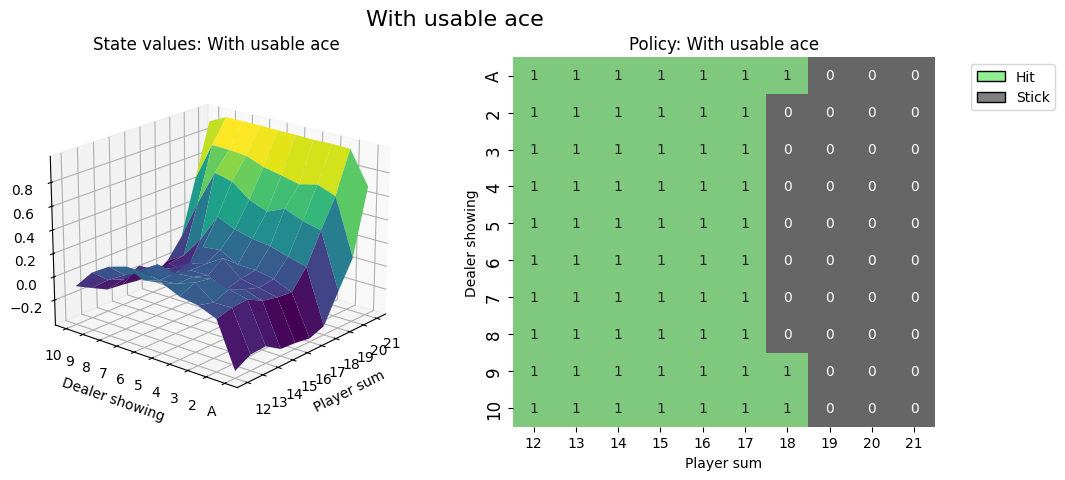

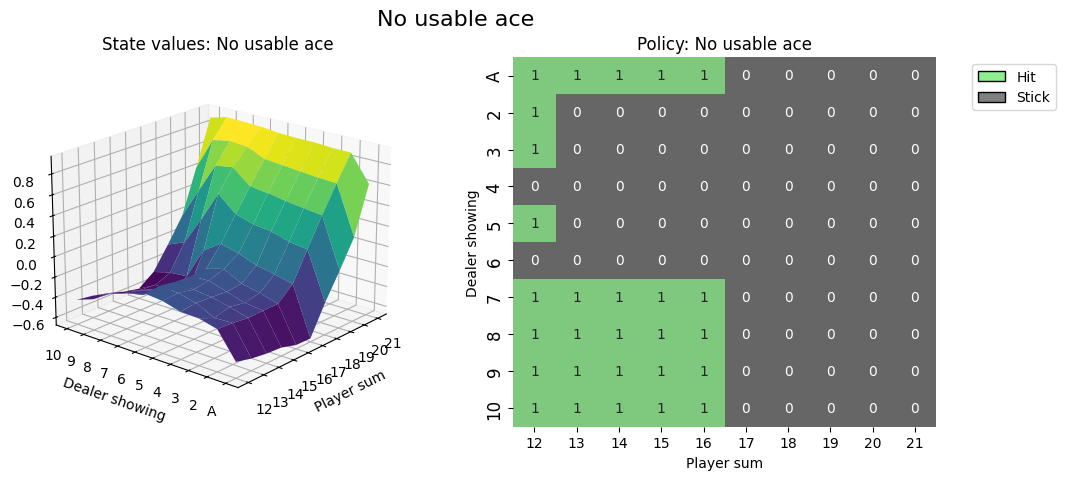

In [91]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(q_values, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(q_values, usable_ace=False)
fig1 = create_plots(value_grid, policy_grid, title="No usable ace")
plt.show()

### 5.4 - On Policy First-Visit MC Control (for e-soft policies)
Estimating the optimal policy using an epsilon-greedy policy

In [20]:
def epsilon_soft_policy(Q, state, epsilon=0.01):
    num_actions = len(Q[state])
    
    # Create a probability distribution for the epsilon-soft policy
    probabilities = np.ones(num_actions) * epsilon / num_actions
    best_action = np.argmax(Q[state])
    probabilities[best_action] += 1 - epsilon
    
    # Choose an action based on the probability distribution
    action = np.random.choice(np.arange(num_actions), p=probabilities)
    
    return action

def generate_episode_with_epsilon_soft_policy(env, Q):
    '''
    Args:
        env : gym environment
        Q (dict): dictionary containing action-values

    Returns
        episode (list): list of (state, action, reward) tuples
    '''

    # init episode list
    episode = []

    # reset environment
    state, _ = env.reset()
    terminated = False

    # Initial random action for exploring starts
    action = epsilon_soft_policy(Q, state)

    # Generate an episode with exploring starts
    while not terminated:
        # take an action and get resulting state and reward 
        next_state, reward, terminated, truncated, info = env.step(action)

        # append results of action to episode 
        episode.append((state, action, reward))
        
        # update state 
        state = next_state

        # use q_values table to get best action 
        action = epsilon_soft_policy(Q, state)
    
    return episode

# test 
q_values = defaultdict(lambda: np.zeros(env.action_space.n))
generate_episode_with_epsilon_soft_policy(env, q_values)


[((16, 10, 1), 0, -1.0)]

In [ ]:
num_episodes = 1000
gamma = 1.0
epsilon = 0.1

# initialize policy, state-action value dictionary, and returns dictionary 
# policy = defaultdict(lambda: np.zeros(env.action_space.n)) # initialize policy

policy = lambda state: epsilon_soft_policy(Q, state, epsilon)
q_values = defaultdict(lambda: np.zeros(env.action_space.n)) # create and initialize q table 
returns_sum = defaultdict(lambda: np.zeros(env.action_space.n)) # create and initialize returns object 
returns_counts = defaultdict(lambda: np.zeros(env.action_space.n)) # create and initialize returns object 


# loop over episodes
for i_episode in range(1, num_episodes+1):
    # monitor progress
    if i_episode % 1000 == 0:
        print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
        sys.stdout.flush()
    
    # generate an episode of data using the policy 
    episode = generate_episode_with_epsilon_soft_policy(env, q_values)
    
    # initialize returns for this episode 
    G = 0

    # loop over each step of episode backwards
    for t, (state, action, reward) in enumerate(reversed(episode)):
        t = len(episode) - t
        G = G*gamma + reward 
        # Check if the state-action pair is visited for the first time in the episode
        if (state, action) not in [(tup[0], tup[1]) for tup in episode[:t-1]]:
            # add the return and increment the count (for the purposes of taking the mean later)
            returns_sum[state][action] += G
            returns_counts[state][action] += 1

            # take the average of the returns for each state-action pair and assign to q table
            q_values[state][action] = returns_sum[state][action] / returns_counts[state][action]

            # update policy 
            policy[state] = np.argmax(q_values[state])


In [55]:
import numpy as np
import gymnasium as gym
from collections import defaultdict
from tqdm import tqdm

def epsilon_soft_policy(Q, state, epsilon):
    num_actions = len(Q[state])
    probabilities = np.ones(num_actions) * epsilon / num_actions
    best_action = np.argmax(Q[state])
    probabilities[best_action] += 1 - epsilon
    return np.random.choice(np.arange(num_actions), p=probabilities)

def update_epsilon_soft_policy(Q, epsilon):
    updated_policy = {}
    for state, action_values in Q.items():
        num_actions = len(action_values)
        probabilities = np.ones(num_actions) * epsilon / num_actions
        best_action = np.argmax(action_values)
        probabilities[best_action] += 1 - epsilon
        updated_policy[state] = np.random.choice(np.arange(num_actions), p=probabilities)
    return updated_policy

def generate_episode(env, policy):
    episode = []
    state, _ = env.reset()

    while True:
        action = policy(state)
        next_state, reward, done, _, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state

        if done:
            break

    return episode

def on_policy_monte_carlo_control(env, num_episodes, epsilon, gamma):
    # initialize dictionaries for Q, N, and R
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))  # Count of first visits for each state-action pair
    R = defaultdict(lambda: np.zeros(env.action_space.n))  # Returns of first visits for each state-action pair

    # setup policyu
    policy = lambda state: epsilon_soft_policy(Q, state, epsilon)

    for episode in tqdm(range(num_episodes)):
        episode_data = generate_episode(env, policy)

        G = 0  # Initialize return
        for t in reversed(range(len(episode_data))):
            state, action, reward = episode_data[t]

            G = gamma * G + reward

            if (state, action) not in [(tup[0], tup[1]) for tup in episode_data[:t]]:
                N[state][action] += 1
                R[state][action] += G
                # Q[state][action] += (G - Q[state][action]) / N[state][action] # incremental update 
                Q[state][action] = R[state][action] / N[state][action] # average over all episodes 

                # Update the epsilon-soft policy based on the updated Q-values
                policy = lambda state: epsilon_soft_policy(Q, state, epsilon)

    return Q, policy

# Create the Blackjack environment
env = gym.make("Blackjack-v1")

# Set hyperparameters
num_episodes = 500000
epsilon = 0.1
gamma = 1.0  # No discounting for simplicity

# Run on-policy Monte Carlo control
optimal_Q, optimal_policy = on_policy_monte_carlo_control(env, num_episodes, epsilon, gamma)

# Display the optimal policy
print("Optimal Policy:")
for state, action_values in optimal_Q.items():
    optimal_action = np.argmax(action_values)
    print(f"State: {state}, Optimal Action: {optimal_action}")

env.close()


100%|██████████| 500000/500000 [01:25<00:00, 5856.09it/s]

Optimal Policy:
State: (21, 10, 1), Optimal Action: 0
State: (7, 3, 0), Optimal Action: 1
State: (14, 10, 0), Optimal Action: 1
State: (11, 10, 0), Optimal Action: 1
State: (14, 3, 0), Optimal Action: 0
State: (12, 3, 0), Optimal Action: 0
State: (12, 10, 0), Optimal Action: 1
State: (20, 2, 0), Optimal Action: 0
State: (14, 2, 0), Optimal Action: 0
State: (18, 8, 0), Optimal Action: 0
State: (13, 7, 0), Optimal Action: 1
State: (15, 6, 0), Optimal Action: 0
State: (17, 9, 0), Optimal Action: 0
State: (19, 5, 0), Optimal Action: 0
State: (11, 2, 0), Optimal Action: 1
State: (14, 4, 0), Optimal Action: 0
State: (16, 5, 0), Optimal Action: 0
State: (8, 4, 0), Optimal Action: 1
State: (14, 1, 0), Optimal Action: 1
State: (20, 5, 0), Optimal Action: 0
State: (6, 10, 0), Optimal Action: 1
State: (12, 5, 0), Optimal Action: 0
State: (15, 10, 1), Optimal Action: 1
State: (8, 3, 0), Optimal Action: 1
State: (9, 6, 0), Optimal Action: 1
State: (14, 6, 1), Optimal Action: 1
State: (19, 6, 0), Op

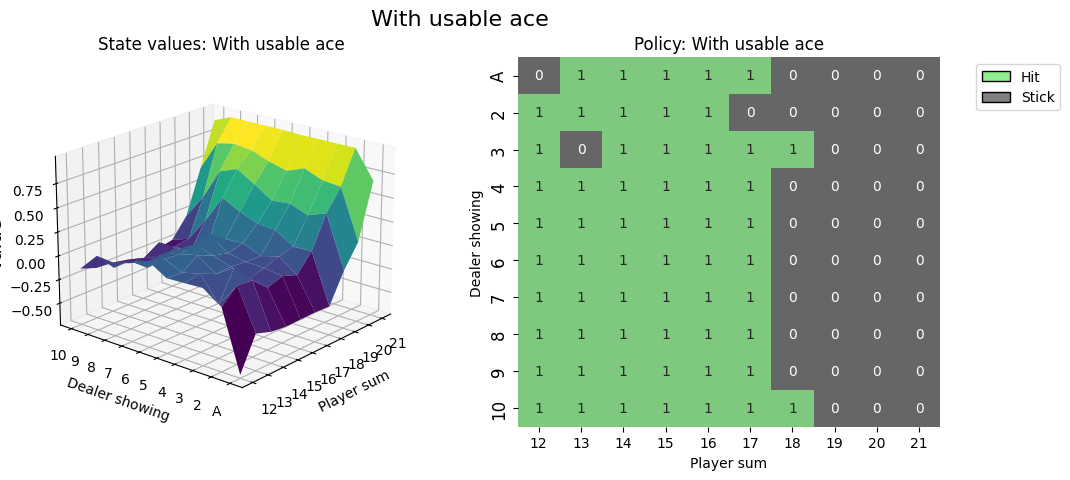

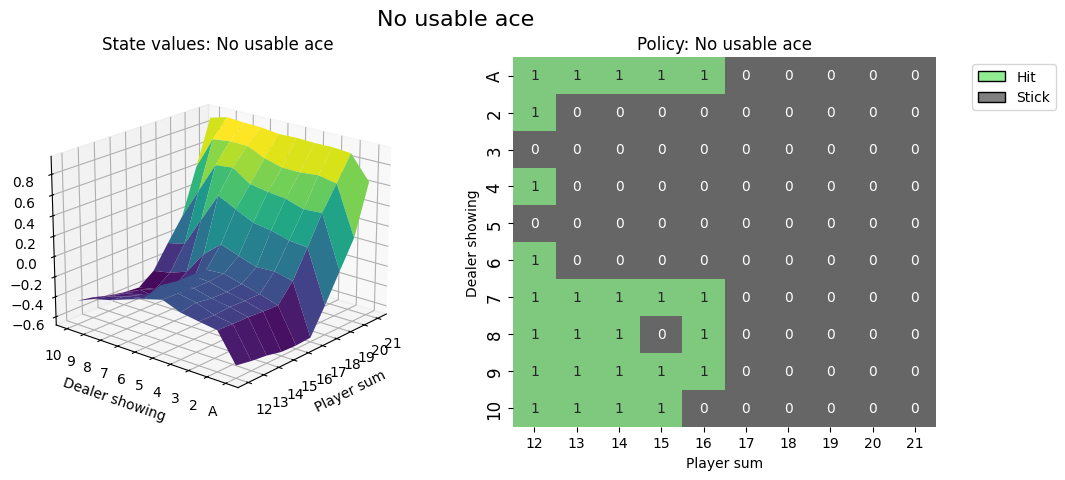

In [56]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(optimal_Q, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(optimal_Q, usable_ace=False)
fig1 = create_plots(value_grid, policy_grid, title="No usable ace")
plt.show()

### 5.7 Off Policy MC Control, for estimating the optimal policy 

In [5]:
import numpy as np
import gymnasium as gym
from collections import defaultdict
from tqdm import tqdm

def epsilon_soft_policy(Q, state, epsilon):
    num_actions = len(Q[state])
    probabilities = np.ones(num_actions) * epsilon / num_actions
    best_action = np.argmax(Q[state])
    probabilities[best_action] += 1 - epsilon
    return np.random.choice(np.arange(num_actions), p=probabilities)

def get_epsilon_soft_policy_action_probability(Q, state, action, epsilon):
    num_actions = len(Q[state])
    probabilities = np.ones(num_actions) * epsilon / num_actions
    best_action = np.argmax(Q[state])
    probabilities[best_action] += 1 - epsilon
    return probabilities[action]

def update_epsilon_soft_policy(Q, epsilon):
    updated_policy = {}
    for state, action_values in Q.items():
        num_actions = len(action_values)
        probabilities = np.ones(num_actions) * epsilon / num_actions
        best_action = np.argmax(action_values)
        probabilities[best_action] += 1 - epsilon
        updated_policy[state] = np.random.choice(np.arange(num_actions), p=probabilities)
    return updated_policy

def generate_episode(env, policy):
    episode = []
    state, _ = env.reset()

    while True:
        action = policy(state)
        next_state, reward, done, _, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state

        if done:
            break

    return episode

def greedy_policy(Q, state):
    return np.argmax(Q[state])


def off_policy_monte_carlo_control(env, num_episodes, epsilon, gamma):
    # initialize dictionaries for Q, N, and R
    # initialize Z to a default dictionary of arrays initialized to random values

    Q = defaultdict(lambda: np.random.random(env.action_space.n))
    C = defaultdict(lambda: np.zeros(env.action_space.n))

    # setup target policy (greedy)
    target_policy = lambda state: greedy_policy(Q, state)

    # setup behavior policy (epsilon-soft)
    behavior_policy = lambda state: epsilon_soft_policy(Q, state, epsilon)
    behavior_policy_action_probability = lambda state, action: get_epsilon_soft_policy_action_probability(Q, state, action, epsilon)

    # loop over episodes
    for episode in tqdm(range(num_episodes)):

        # generate an episode using the behavior policy
        episode_data = generate_episode(env, behavior_policy)

        G = 0  # Initialize return
        W = 1 # Initialize weight

        # loop through each step of episode, backwards in time
        for t in reversed(range(len(episode_data))):
            
            # get state, action, and reward at time step t
            state, action, reward = episode_data[t]

            # update return
            G = gamma * G + reward

            # update weight
            C[state][action] = C[state][action] + W

            # update q table
            Q[state][action] = Q[state][action] + (W / C[state][action]) * (G - Q[state][action])

            # Update weight
            if action != target_policy(state):
                break
            W *= 1. / behavior_policy_action_probability(state, action)    

    return Q, target_policy 


#### Utilize Off Policy MC Control to solve Blackjack

100%|██████████| 1000000/1000000 [03:17<00:00, 5050.97it/s]


Optimal Policy:
State: (17, 2, 0), Optimal Action: 0
State: (13, 6, 0), Optimal Action: 0
State: (15, 6, 0), Optimal Action: 0
State: (12, 8, 0), Optimal Action: 1
State: (9, 7, 0), Optimal Action: 1
State: (11, 7, 0), Optimal Action: 1
State: (21, 7, 0), Optimal Action: 0
State: (14, 2, 0), Optimal Action: 0
State: (21, 2, 0), Optimal Action: 0
State: (19, 8, 0), Optimal Action: 0
State: (20, 8, 0), Optimal Action: 0
State: (14, 10, 0), Optimal Action: 1
State: (16, 10, 0), Optimal Action: 0
State: (18, 10, 0), Optimal Action: 0
State: (21, 10, 1), Optimal Action: 0
State: (15, 8, 0), Optimal Action: 1
State: (17, 9, 0), Optimal Action: 0
State: (15, 10, 0), Optimal Action: 1
State: (9, 10, 0), Optimal Action: 1
State: (10, 6, 0), Optimal Action: 1
State: (13, 8, 0), Optimal Action: 1
State: (16, 8, 0), Optimal Action: 1
State: (20, 1, 0), Optimal Action: 0
State: (12, 5, 0), Optimal Action: 0
State: (14, 5, 0), Optimal Action: 0
State: (16, 5, 0), Optimal Action: 0
State: (18, 3, 0),

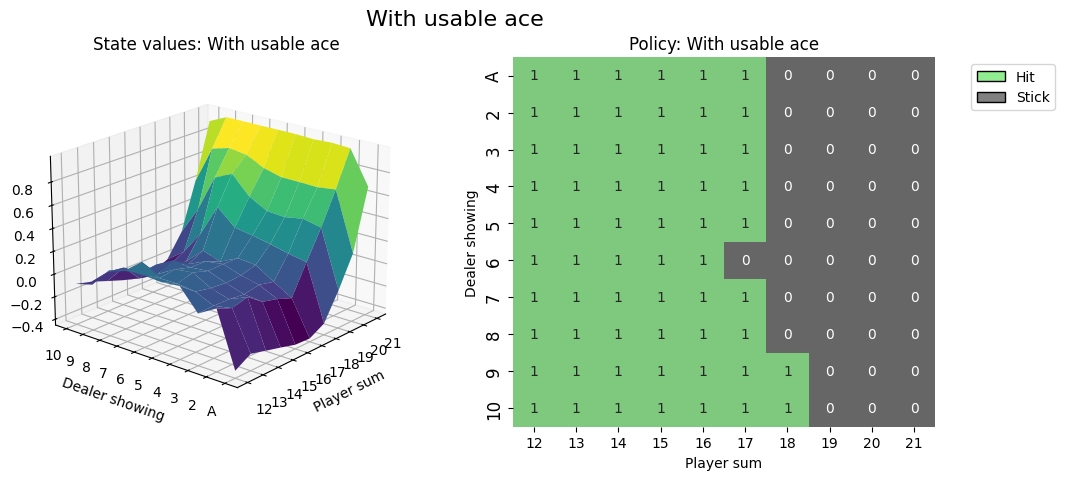

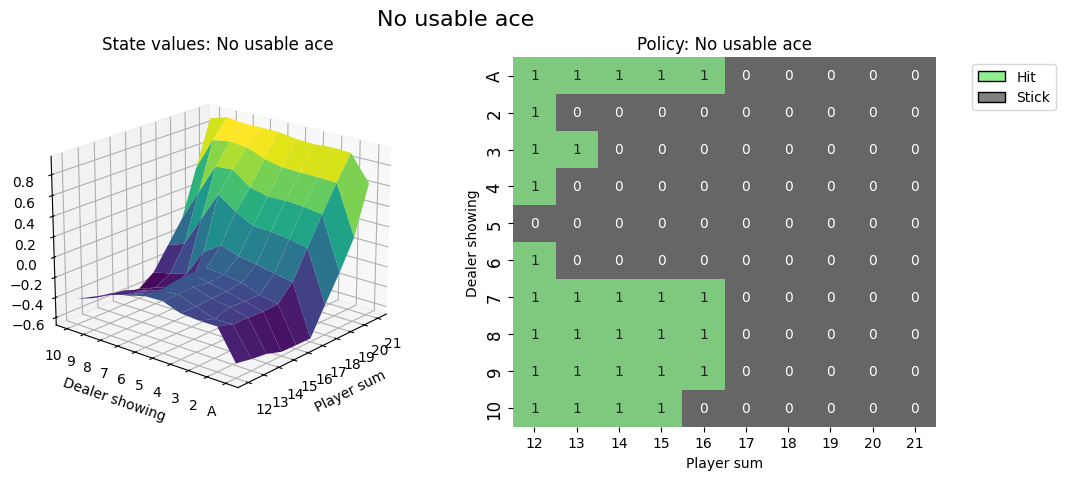

In [69]:

# Create the Blackjack environment
env = gym.make("Blackjack-v1")

# Set hyperparameters
num_episodes = 1000000
epsilon = 0.1
gamma = 1.0  # No discounting for simplicity

# Run on-policy Monte Carlo control
optimal_Q, optimal_policy = off_policy_monte_carlo_control(env, num_episodes, epsilon, gamma)

# Display the optimal policy
print("Optimal Policy:")
for state, action_values in optimal_Q.items():
    optimal_action = np.argmax(action_values)
    print(f"State: {state}, Optimal Action: {optimal_action}")

env.close()

# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(optimal_Q, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(optimal_Q, usable_ace=False)
fig1 = create_plots(value_grid, policy_grid, title="No usable ace")
plt.show()

#### Off Policy MC Control for Frozen Lake

In [1]:
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
from typing import NamedTuple
from pathlib import Path

class Params(NamedTuple):
    total_episodes: int  # Total episodes
    learning_rate: float  # Learning rate
    gamma: float  # Discounting rate
    epsilon: float  # Exploration probability
    map_size: int  # Number of tiles of one side of the squared environment
    seed: int  # Define a seed so that we get reproducible results
    is_slippery: bool  # If true the player will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions
    n_runs: int  # Number of runs
    action_size: int  # Number of possible actions
    state_size: int  # Number of possible states
    proba_frozen: float  # Probability that a tile is frozen
    savefig_folder: Path  # Root folder where plots are saved

In [70]:
# writen a function that takes a dictionary that contains an array for each key, and returns a numpy array with the same keys and the max value for each array
def dict_to_array_max(dict, map_size):
    array = np.zeros(map_size*map_size)
    for state in dict.keys():
        array[state] = dict[state].max()
    return array

# write a function that takes a dictionary that contains an array for each key, and returns a numpy array with the same keys and the argmax value for each array
def dict_to_array_argmax(dict, map_size):
    array = np.zeros(map_size*map_size)
    for state in dict.keys():
        array[state] = dict[state].argmax()
    return array


def qtable_directions_map(qtable, map_size):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = dict_to_array_max(qtable, map_size).reshape(map_size, map_size)
    qtable_best_action = dict_to_array_argmax(qtable, map_size).reshape(map_size, map_size)
    # qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    # qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

def plot_q_values_map(qtable, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    img_title = f"frozenlake_q_values_{map_size}x{map_size}.png"
    # fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

100%|██████████| 50000/50000 [01:01<00:00, 806.71it/s] 


Optimal Policy:
State: 0, Optimal Action: 0
State: 4, Optimal Action: 0
State: 5, Optimal Action: 0
State: 1, Optimal Action: 2
State: 8, Optimal Action: 3
State: 12, Optimal Action: 3
State: 13, Optimal Action: 2
State: 14, Optimal Action: 1
State: 2, Optimal Action: 3
State: 9, Optimal Action: 2
State: 10, Optimal Action: 1
State: 3, Optimal Action: 1
State: 7, Optimal Action: 2
State: 11, Optimal Action: 2


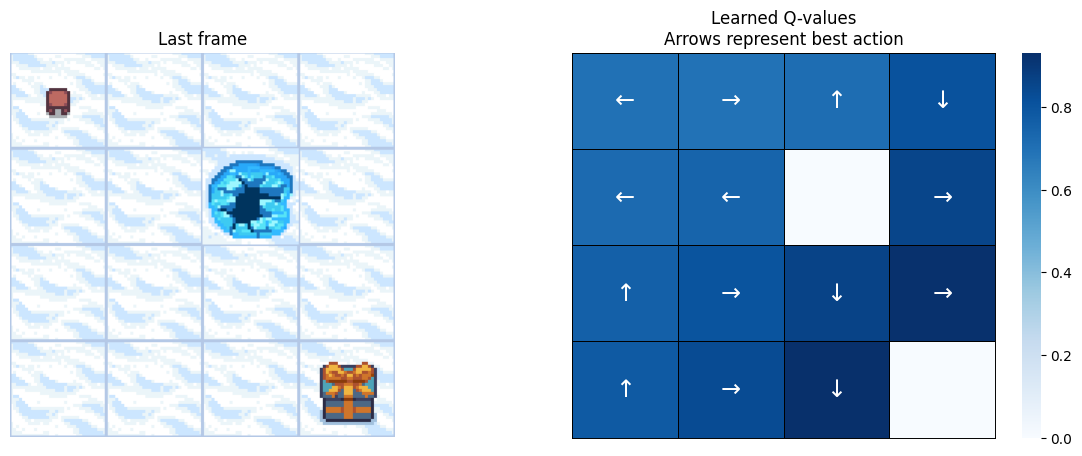

In [71]:
params = Params(
    total_episodes=50000,
    learning_rate=None,
    gamma=0.95,
    epsilon=0.5,
    map_size=4,
    seed=123,
    is_slippery=True,
    n_runs=None,
    action_size=None,
    state_size=None,
    proba_frozen=0.9,
    savefig_folder=Path("./"),
)

env = gym.make(
    "FrozenLake-v1",
    is_slippery=params.is_slippery,
    render_mode="rgb_array",
    desc=generate_random_map(
        size=params.map_size, p=params.proba_frozen, seed=params.seed
    ),
)


# Run on-policy Monte Carlo control
optimal_Q, optimal_policy = off_policy_monte_carlo_control(env, params.total_episodes, params.epsilon, params.gamma)

# Display the optimal policy
print("Optimal Policy:")
for state, action_values in optimal_Q.items():
    optimal_action = np.argmax(action_values)
    print(f"State: {state}, Optimal Action: {optimal_action}")

env.close()

plot_q_values_map(optimal_Q, env, params.map_size)